<a href="https://colab.research.google.com/github/g8428/TIL/blob/master/220217_deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import numpy as np
import pickle


def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    def _change_one_hot_label(X):
        T = np.zeros((X.size, 10))
        for idx, row in enumerate(T):
            row[X[idx]] = 1

        return T


    with open('/content/drive/MyDrive/2022-1/국비지원교육/실습폴더/mnist.pkl의 사본', 'rb') as f:
        dataset = pickle.load(f)

    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0

    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])

    if not flatten:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']),  (dataset['test_img'], dataset['test_label'])

In [58]:
# loss 구하는 함수
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]

    if y.size == t.size:
        t = t.argmax(axis=1)

    delta = 1e-7
    return -np.sum(np.log(y[np.arange(batch_size),t] + delta))/batch_size

In [59]:
# 네트워크 내 계산 시그모이드 함수
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [60]:
# 네트워크 끝 계산 소프트 맥스
def softmax(x):
    exp_x = np.exp(x)
    sum_exp_x = sum(exp_x)
    y = exp_x / sum_exp_x

    return y

In [61]:
# W값 업데이트 용 편미분
def _numerical_gradient_no_batch(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]

        #f(x+h)
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)

        #f(x-h)
        x[idx] = float(tmp_val) - h 
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val

    return grad

In [62]:
# 미분
def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)

        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)

        return grad

In [63]:
# 2단계 네트워크 만들기
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] =  weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    # 네트워크와 입력값 내적해서 출력값 생성(forward)
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        # 1단계 인풋, 아웃풋
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1) # 활성화 함수

        # 2단계 인풋, 아웃풋
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2) # logit 소프트맥스

        return y

    # loss  구하기(잔차)
    def loss(self, x, t) :
        # p = 예측값, t = 정답 라벨값
        p = self.predict(x)
        return cross_entropy_error(p, t)
    
    # 정확도 구하기
    def accuracy(self, x, t):
        y = self.predict(x)

        #y,t는 원핫 형식 -> 라벨형식으로
        y = np.argmax(y, axis = 1)
        t = np.argmax(t, axis= 1 )

        # 정답 갯수 / 전체 갯수
        accuracy = np.sum(y == t)/float(x.shape[0])
        
        return accuracy
    
    # W값 업데이트 (편미분) 각 파라미터의 기울기 구하기
    def numerical_gradient(self, x, t):
        # 목적함수 - cross entropy
        loss_W = lambda W : self.loss(x,t)

        # 목적함수에 대해 각 파라미터 편미분, 업데이트
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])

        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads


In [64]:
import pickle
# 데이터 로드 - 원핫 형식으로 (network 객체 내에서 라벨 형식으로 변환 예정)
(x_train, y_train), (x_test, y_test) = load_mnist(normalize=True, flatten=True, one_hot_label=True) 

In [35]:
x_train.shape, y_train.shape

((60000, 784), (60000, 10))

## 불러온 데이터로 네트워크 돌려보기

In [65]:
# 2층  신경망 네트워크 객체 생성
network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

In [37]:
print(network.params['W1'].shape)
print(network.params['b1'].shape)
print(network.params['W2'].shape)
print(network.params['b2'].shape)

(784, 50)
(50,)
(50, 10)
(10,)


In [66]:
x = np.random.rand(50,784)
y = network.predict(x)
np.argmax(y[0]) # 최댓값 인덱스 반환

7

In [67]:
# W값 업데이트 위해 반복학습
iters_num = 10000
train_size = x_train.shape[0] # 6만개
batch_size = 100 # 미니배치 사이즈 (배치 떠와서 학습)
learning_rate = 0.01 # 학습률

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size/batch_size, 1) # 1에폭당 반복횟수, 최소 한번
# 배치/에폭 에폭은 전체사이즈, 배치는 표본 사이즈

In [ ]:
# 학습
for i in range(iters_num):

    batch_mask = np.random.choice(train_size, batch_size) #트레인에서 배치크기만큼 선택(중복가능)
    x_batch = x_train[batch_mask] # 인덱스값 -> train의 값
    y_batch = y_train[batch_mask]

    # 파라미터 업데이트 위한 grad 값 업데이트
    grad = network.numerical_gradient(x_batch, y_batch)

    # 파라미터 갱신 (예: w = w - learning rate * 기울기(미분값))
    for key in ('W1','b1','W2','b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 파라미터 갱신 후 loss 값
    loss = network.loss(x_batch, y_batch)
    train_loss_list.append(loss) #loss 값 히스토리

    # 업데이트 후 정확도 계산
    train_acc = network.accuracy(x_train, y_train)
    # 테스트 데이터 정확도
    test_acc = network.accuracy(x_test, y_test)

    train_acc_list.append(train_acc) # 정확도 히스토리
    test_acc_list.append(test_acc)

    print(f'loss {loss}, train_acc {train_acc}, test_acc {test_acc}')
    

### 합성함수 미분
    - 밖에 거 미분 하고
        - 안에거 미분
        - 연쇄법칙

### 덧셈노드의 역전파 z = x+y
    - backward 계산법
    - x에 대해 미분하면 1, y에 대해 미분하면 1
    - 합성함수 미분한 값을 알고 있으면
        - 안에거 각각 미분한 값을 몰라도 된다
        - 함성함수 미분한 값이 곧 안에거 미분한 값

### 곱셈 노드의 역전파 z = x * y
    - x에 대해 미분하면 y
    - y에 대해 미분하면 x
    - 강의안 참고
    - x값 = 함성함수미분값 * y
    - y값 = 함성함수미분값 * x 
        - 바꿔서 곱해주면 된다

### 역전파의 의의
    - 목적함수와 최종값을 가지고
    - 각 feature의 영향력(변화량 = 미분값)을 알 수 있다
    - 임의로 1로 둔 값에 목적함수를 넣으면 됨

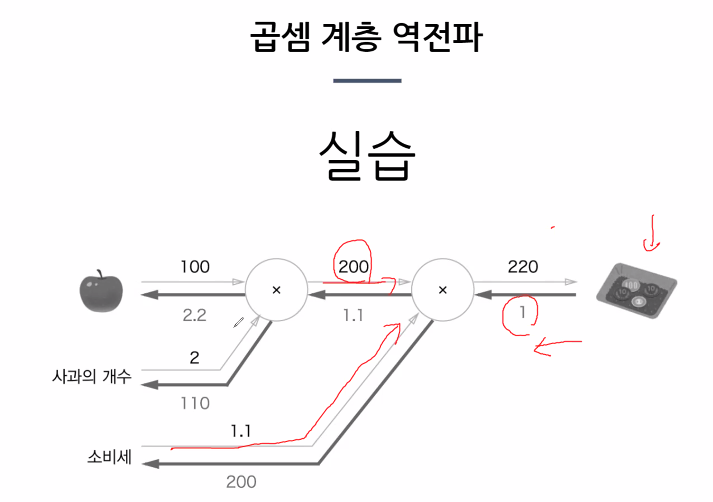

- 같은 원리로 backward를 하면 sigmoid, 목적함수, softmax 등을 역전파로 만들어 곱으로 나타낼 수 있다